In [33]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [34]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 12
--n_colours 2
--height 8
--width 8
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
feat_map.shape

test
start positions:  [[5, 3]]
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration


(64, 4)

In [35]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)
inputs.size()

torch.Size([64, 4])

In [38]:
m = nn.Dropout(0.25)
x = torch.randn(2, 3)
m(x)

tensor([[ 2.1936,  0.3852, -1.6616],
        [-2.8745, -0.5671, -0.0000]])

In [11]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]

idx = 16
print(env.idx2pos(idx))
print(inputs[16, :])
print(inputs_img[0, :, 0, 2])

(0, 2)
tensor([2.2361, 2.0000, 2.0000, 2.2361])
tensor([2.2361, 2.0000, 2.0000, 2.2361])


In [12]:
from collections import Counter
hiddens = [32, 32, 16, 16, 8]
Counter(hiddens)

Counter({32: 2, 16: 2, 8: 1})

In [13]:
from collections import Counter

def build_block(input_dim, output_dim, kernel_size=3, stride=1, padding=1, dropout=0.25):
    return [
        nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ELU(),
        nn.Dropout(dropout)
    ]

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c,  downsample=None):
        super().__init__()
        self.conv = nn.Sequential(
            *build_block(in_c, out_c, kernel_size=3, stride=1, padding=1)
        )
        self.act = nn.ELU()
        self.downsample = downsample
        self.out_c = out_c

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.act(out)
        return out

class DeepIRLCNN(nn.Module):
    def __init__(self, input_dim, hiddens: list[int], output_dim: int=1):
        super(DeepIRLCNN, self).__init__()
        self.input_dim = input_dim
        self.hiddens = hiddens
        self.output_dim = output_dim
        self.layers = nn.ModuleList()
        
        # init block always build additional blocks as the same dim with hiddens[0]
        # e.g. out_channel = hiddens = [32, 32, 16, 16, 8]
        # first layer channel: input_dim > 32
        # layers = {32: 2, 16: 2, 8: 1}
        self.in_c = hiddens[0]
        blocks_count = Counter(hiddens)
        self.layers.append(nn.Sequential(*build_block(input_dim, self.in_c)))
        for out_c, n_blocks in blocks_count.items():
            self.layers.append(self.build_layers(out_c, n_blocks))
            
        # last layer
        self.layers.append(nn.Sequential(
            nn.Conv2d(self.in_c, output_dim, kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        ))

    def build_layers(self, out_c, n_blocks):
        downsample = None
        if self.in_c != out_c:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_c, out_c, kernel_size=1, stride=1, padding=0),
                nn.ELU()
            )
        layers = []
        layers.append(ResidualBlock(self.in_c, out_c, downsample))
        self.in_c = out_c
        for l in range(1, n_blocks):
            layers.append(ResidualBlock(self.in_c, out_c, downsample=None))
        return nn.Sequential(*layers)
              
    def forward(self, x):
        """Get reward"""
        grid_size = int(np.sqrt(x.size(0)))
        # x: SxD -> 1xDxHxW
        x = x.view(grid_size, grid_size, self.input_dim).permute(2, 1, 0)[None,]
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.squeeze()  # 1x1xHxW -> HxW
        # x: 1xHxW -> Sx1
        return x.permute(1, 0).reshape(-1, 1)

In [48]:
output_dim = 1
hiddens = [32, 32, 16, 16, 8]
input_dim = 2*args.n_colours
model = DeepIRLCNN(input_dim, hiddens, output_dim)
o = model(inputs)

Layer 0
torch.Size([1, 4, 8, 8])
Layer 1
torch.Size([1, 32, 8, 8])
Layer 2
torch.Size([1, 32, 8, 8])
Layer 3
torch.Size([1, 16, 8, 8])
Layer 4
torch.Size([1, 8, 8, 8])


## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [30]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [32]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 15
--n_colours 2
--height 10
--width 10
--gamma 0.9
--act_random 0.3
--n_trajs 20
--l_traj 8
--learning_rate 0.01
--n_iters 50
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 100.0
--weight_decay 0.0
--hiddens 3 3
--device cuda
--active
--seed 3
--verbose 2
--architecture dnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 1 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.8741 -0.8365 -0.7863 -0.721  -0.6546 -0.6391 -0.694  -0.7628 -0.8049
  -0.8403]
 [-0.8699 -0.8318 -0.7788 -0.7055 -0.6198 -0.5435 -0.6586 -0.7468 -0.8011
  -0.831 ]
 [-0.8753 -0.8384 -0.7897 -0.7273 -0.6606 -0.6294 -0.6841 -0.7402 -0.7808
  -0.8112]
 [-0.8865 -0.8544 -0.8159 -0.7712 -0.7314 -0.7154 -0.6829 -0.6686 -0.7158
  -0.7792]
 [-0.8984 -0.8719 -0.8436 -0.8159 -0.7842 -0.7166 -0.6418 -0.5669 -0.6808
  -0.7488]
 [-0.8996 -0.8778 -0.8606 -0.8365 -0.792  -0.7314 -0.6632 -0.6487 -0.6769
  -0.744 ]
 [-0.9044 -0.8836 -0.8547 -0.8295 -0.8072 -0.7695 -0.7273 -0.6937 -0.7181
  -0.7635]
 [-0.8983 -0.8691 -0.8355 -0.8014 -0.7717 -0.7273 -0.6547 -0.6198 -0.6568
  -0.7012]
 [-0.8918 -0.8572 -0.8187 -0.7904 -0.7579 -0.7105 -0.6198 -0.5231 -0.6286
  -0.6283]
 [-0.8922 -0.8582 -0.8199 -0.7901 -0.7707 -0.7289 -0.6632 -0.6226 -0.6241
  -0.5815]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 3.845010 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value ite

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.9338  0.8137  0.5276  0.563  -0.551  -0.8769 -0.9432 -0.9652 -0.9774
  -0.9819]
 [ 0.9599  0.9022  0.8218  0.9221 -0.1308 -0.8977 -0.9421 -0.964  -0.9763
  -0.9812]
 [ 0.9356  0.8291  0.5973  0.6536 -0.5109 -0.9055 -0.9507 -0.9683 -0.9748
  -0.9795]
 [ 0.7941  0.5046 -0.4869 -0.5574 -0.8265 -0.9311 -0.9643 -0.9711 -0.972
  -0.9741]
 [ 0.9288  0.9336  0.843  -0.4869 -0.8925 -0.9492 -0.9514 -0.9602 -0.9557
  -0.9683]
 [ 0.9367  0.9582  0.9107  0.8137 -0.6522 -0.8265 -0.8461 -0.8614 -0.9325
  -0.9589]
 [ 0.8717  0.8967  0.948   0.8365 -0.381   0.4284  0.6536 -0.4956 -0.8637
  -0.9347]
 [ 0.8135  0.8424  0.7346  0.0115 -0.7117  0.6536  0.9009 -0.1308 -0.8364
  -0.8149]
 [ 0.8792  0.937   0.4631 -0.7779 -0.8487 -0.1851 -0.1308 -0.8289 -0.5539
  -0.0613]
 [ 0.7112  0.7209 -0.2435 -0.8583 -0.9266 -0.836  -0.8461 -0.8859 -0.2949
   0.807 ]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 2.612467 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iter

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.1386 -0.1439 -0.1585 -0.1311 -0.2981 -0.3887 -0.5539 -0.665  -0.6644
  -0.6693]
 [-0.1016 -0.1111 -0.1062 -0.01   -0.2668 -0.5301 -0.5943 -0.6798 -0.6816
  -0.7232]
 [-0.1425 -0.1472 -0.1597 -0.1309 -0.34   -0.5592 -0.6425 -0.7241 -0.7503
  -0.7721]
 [-0.2167 -0.2134 -0.3034 -0.3297 -0.4673 -0.6124 -0.7162 -0.7427 -0.7351
  -0.7436]
 [-0.1909 -0.139  -0.1481 -0.3034 -0.5291 -0.6671 -0.6545 -0.6788 -0.6249
  -0.6587]
 [-0.1369 -0.0786 -0.1049 -0.1439 -0.3564 -0.4673 -0.4938 -0.4624 -0.446
  -0.5555]
 [-0.1236 -0.0773 -0.0204 -0.0713 -0.2526 -0.1758 -0.1309 -0.2825 -0.3575
  -0.4615]
 [-0.0967 -0.0466 -0.036  -0.1054 -0.319  -0.1309 -0.0119 -0.2668 -0.3096
  -0.3408]
 [-0.0566  0.0224 -0.0123 -0.1387 -0.3239 -0.2596 -0.2668 -0.4951 -0.3378
  -0.3096]
 [-0.0718 -0.0143 -0.021  -0.0755 -0.3668 -0.4485 -0.4938 -0.5527 -0.384
  -0.3111]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 2.393746 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value itera

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.5408  0.4837  0.4067  0.3731  0.151   0.0195 -0.1278 -0.2403 -0.3089
  -0.3506]
 [ 0.5771  0.5175  0.469   0.5259  0.1914 -0.1474 -0.1822 -0.2641 -0.3136
  -0.4043]
 [ 0.5411  0.487   0.4174  0.3936  0.1439 -0.1398 -0.239  -0.3497 -0.3784
  -0.4397]
 [ 0.4874  0.4393  0.2938  0.2256  0.0515 -0.1612 -0.3702 -0.4346 -0.3936
  -0.3654]
 [ 0.532   0.5397  0.4924  0.2938  0.0178 -0.2523 -0.2839 -0.3679 -0.22
  -0.2627]
 [ 0.5553  0.585   0.5349  0.4837  0.2174  0.0515 -0.0283 -0.0075 -0.0467
  -0.1454]
 [ 0.5412  0.5503  0.586   0.5078  0.3085  0.3791  0.3936  0.1802  0.0712
  -0.0226]
 [ 0.5353  0.5381  0.5018  0.3707  0.1768  0.3936  0.4922  0.1914  0.0853
   0.094 ]
 [ 0.5572  0.5922  0.4606  0.2225  0.1109  0.2471  0.1914 -0.1106  0.1249
   0.185 ]
 [ 0.526   0.5212  0.3796  0.2309  0.0361  0.0541 -0.0283 -0.1331  0.1088
   0.2779]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 2.691586 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value itera

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.3813  0.2239  0.1661  0.2771  0.1997  0.413   0.0485 -0.2835  0.0462
   0.3999]
 [ 0.466   0.3494  0.3087  0.4743  0.1954  0.0403 -0.1119 -0.3512 -0.1083
   0.0098]
 [ 0.3768  0.2195  0.1608  0.2693  0.0439 -0.2335 -0.333  -0.4883 -0.3999
  -0.3492]
 [ 0.059   0.0011 -0.1455 -0.1037 -0.228  -0.4261 -0.4898 -0.4078 -0.3505
  -0.3946]
 [ 0.3032  0.3749  0.2262 -0.1455 -0.3775 -0.5106 -0.3454 -0.1865 -0.0264
  -0.1318]
 [ 0.4557  0.5106  0.4115  0.2239 -0.1725 -0.228  -0.192   0.0883  0.4083
   0.0884]
 [ 0.4437  0.4983  0.5532  0.4173 -0.0444  0.1391  0.2693  0.0998  0.2073
   0.0402]
 [ 0.4597  0.5078  0.4746  0.2822 -0.0646  0.2693  0.4718  0.1954  0.4496
   0.2052]
 [ 0.5374  0.5987  0.4873  0.3744  0.123   0.0837  0.1954 -0.0526  0.1597
   0.04  ]
 [ 0.4728  0.5259  0.4811  0.5605  0.2426 -0.1547 -0.192  -0.2841 -0.1513
  -0.2382]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 2.939781 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value ite

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.1631  0.0221 -0.1034 -0.0472 -0.2638 -0.2916 -0.6008 -0.7603 -0.6879
  -0.5958]
 [ 0.2397  0.1182  0.0422  0.2099 -0.234  -0.5619 -0.6709 -0.784  -0.7346
  -0.7483]
 [ 0.1614  0.0196 -0.1072 -0.0538 -0.3582 -0.6404 -0.7434 -0.8341 -0.8494
  -0.8526]
 [-0.0445 -0.1779 -0.3979 -0.4072 -0.5563 -0.7259 -0.826  -0.8419 -0.8321
  -0.8435]
 [ 0.1307  0.1586  0.0318 -0.3979 -0.6486 -0.7864 -0.7539 -0.7588 -0.6978
  -0.7323]
 [ 0.2086  0.2628  0.1752  0.0221 -0.4529 -0.5563 -0.5672 -0.4981 -0.3592
  -0.578 ]
 [ 0.2093  0.2349  0.2888  0.1716 -0.2958 -0.157  -0.0538 -0.2634 -0.3193
  -0.4733]
 [ 0.2227  0.2457  0.2232  0.0695 -0.3465 -0.0538  0.1892 -0.234  -0.1607
  -0.3038]
 [ 0.263   0.3213  0.2405  0.0348 -0.2896 -0.2786 -0.234  -0.5235 -0.3318
  -0.3315]
 [ 0.2365  0.2668  0.2223  0.1751 -0.3045 -0.5172 -0.5672 -0.6371 -0.4409
  -0.4428]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 2.524105 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value ite

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.3079  0.1355  0.035   0.1684 -0.1502 -0.5076 -0.7679 -0.8802 -0.9017
  -0.9148]
 [ 0.4825  0.2766  0.2199  0.5311 -0.0111 -0.5932 -0.7786 -0.8812 -0.9088
  -0.9398]
 [ 0.2964  0.1219  0.0175  0.1403 -0.1969 -0.5991 -0.7975 -0.8977 -0.9444
  -0.9579]
 [-0.0315 -0.1385 -0.3548 -0.3308 -0.4939 -0.7021 -0.8637 -0.9145 -0.9254
  -0.9403]
 [ 0.1978  0.2958  0.1313 -0.3548 -0.6334 -0.7763 -0.7886 -0.8442 -0.8539
  -0.885 ]
 [ 0.4471  0.5911  0.3976  0.1355 -0.402  -0.4939 -0.4773 -0.5885 -0.6354
  -0.7831]
 [ 0.519   0.5902  0.6882  0.4616 -0.2027 -0.024   0.1403 -0.0616 -0.3915
  -0.6148]
 [ 0.5849  0.6416  0.6105  0.3678 -0.2096  0.1403  0.5212 -0.0111 -0.3409
  -0.3276]
 [ 0.6771  0.7618  0.6593  0.1347 -0.2808 -0.1261 -0.0111 -0.3584 -0.2427
  -0.0621]
 [ 0.6397  0.6979  0.6016  0.1482 -0.4776 -0.4757 -0.4773 -0.5182 -0.0649
   0.1815]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 2.018002 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value ite

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

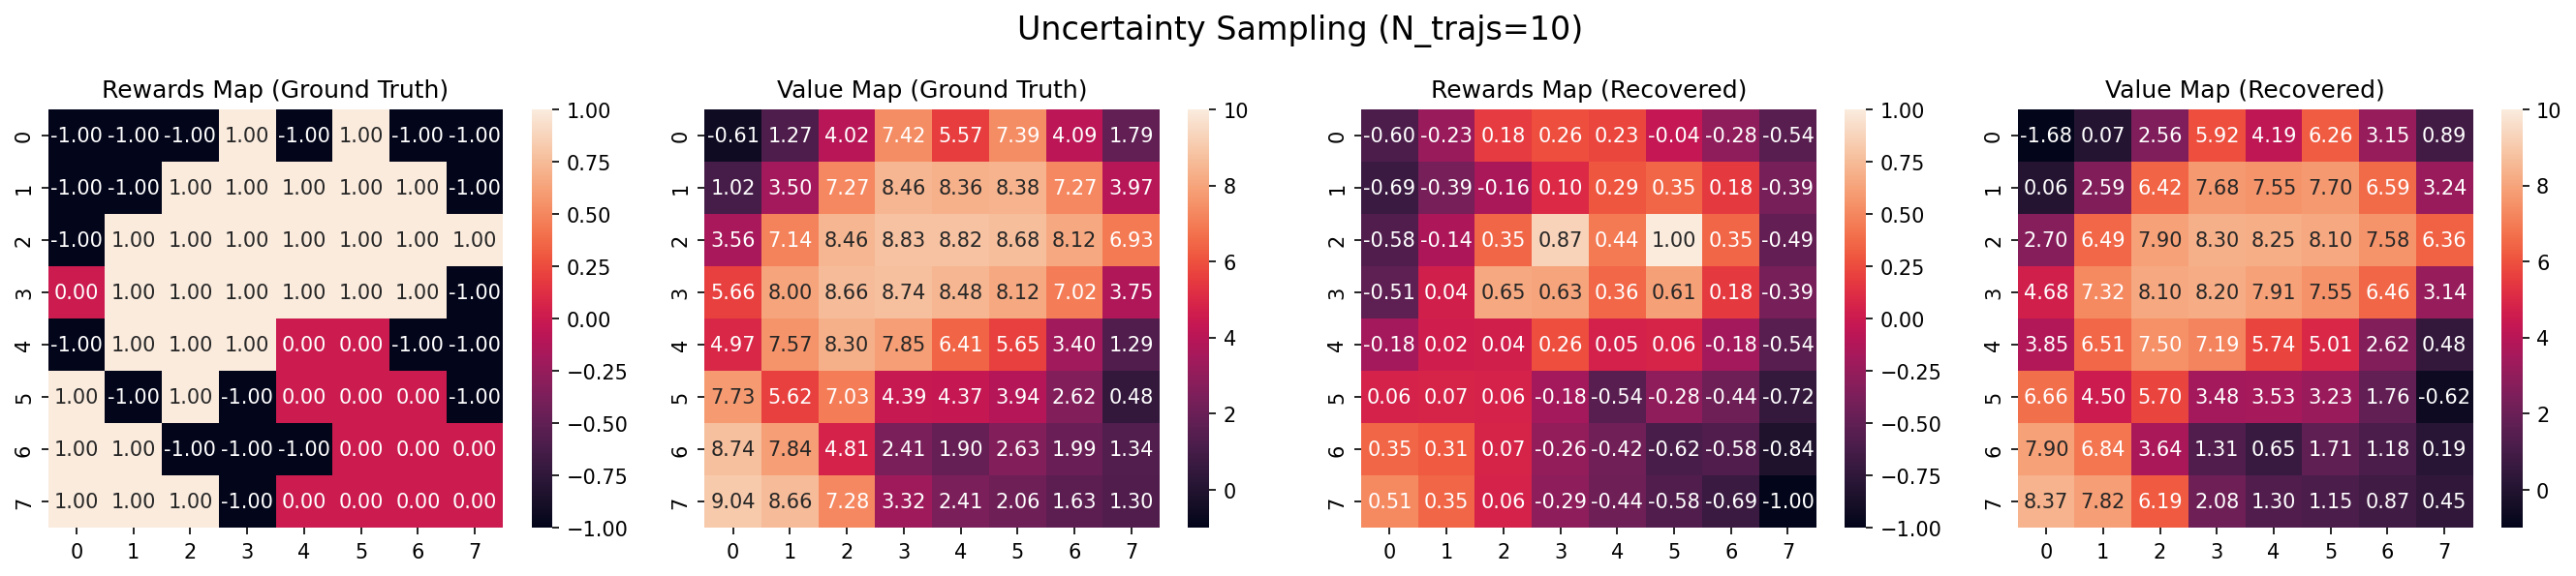

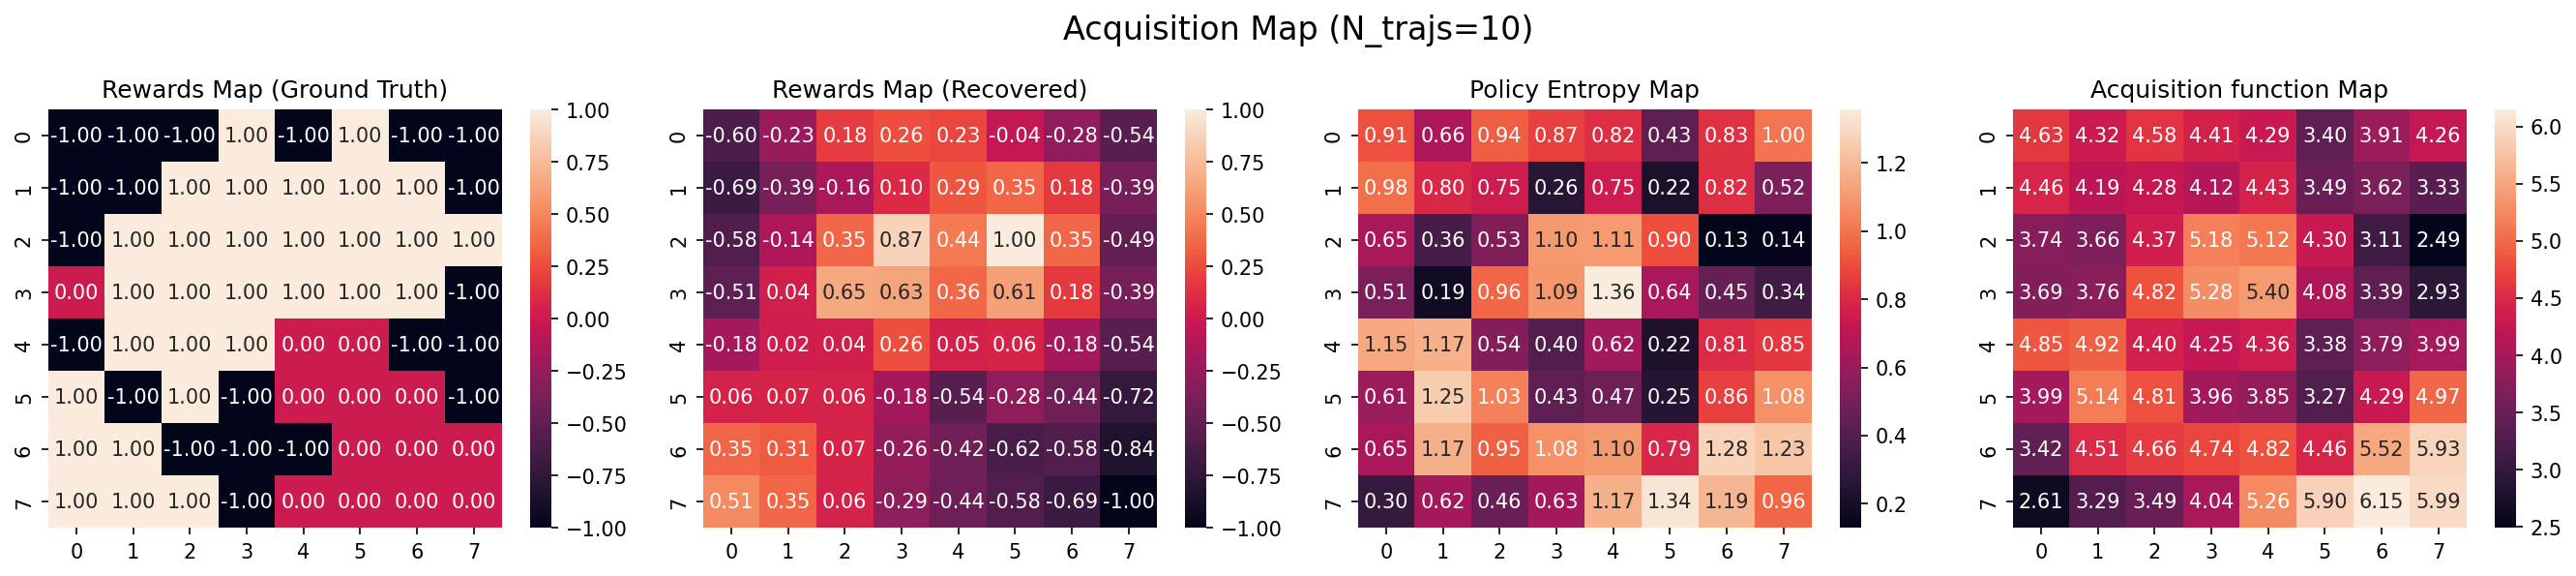

In [28]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)

In [91]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 16
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.0001
--n_iters 30
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.01
--hiddens 32 32 16 8
--device cuda
--active
--seed 3
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL
DeepIRLCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): Sequential(
     

  0%|          | 0/30 [00:00<?, ?it/s]

0


TypeError: conv2d() received an invalid combination of arguments - got (Sequential, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


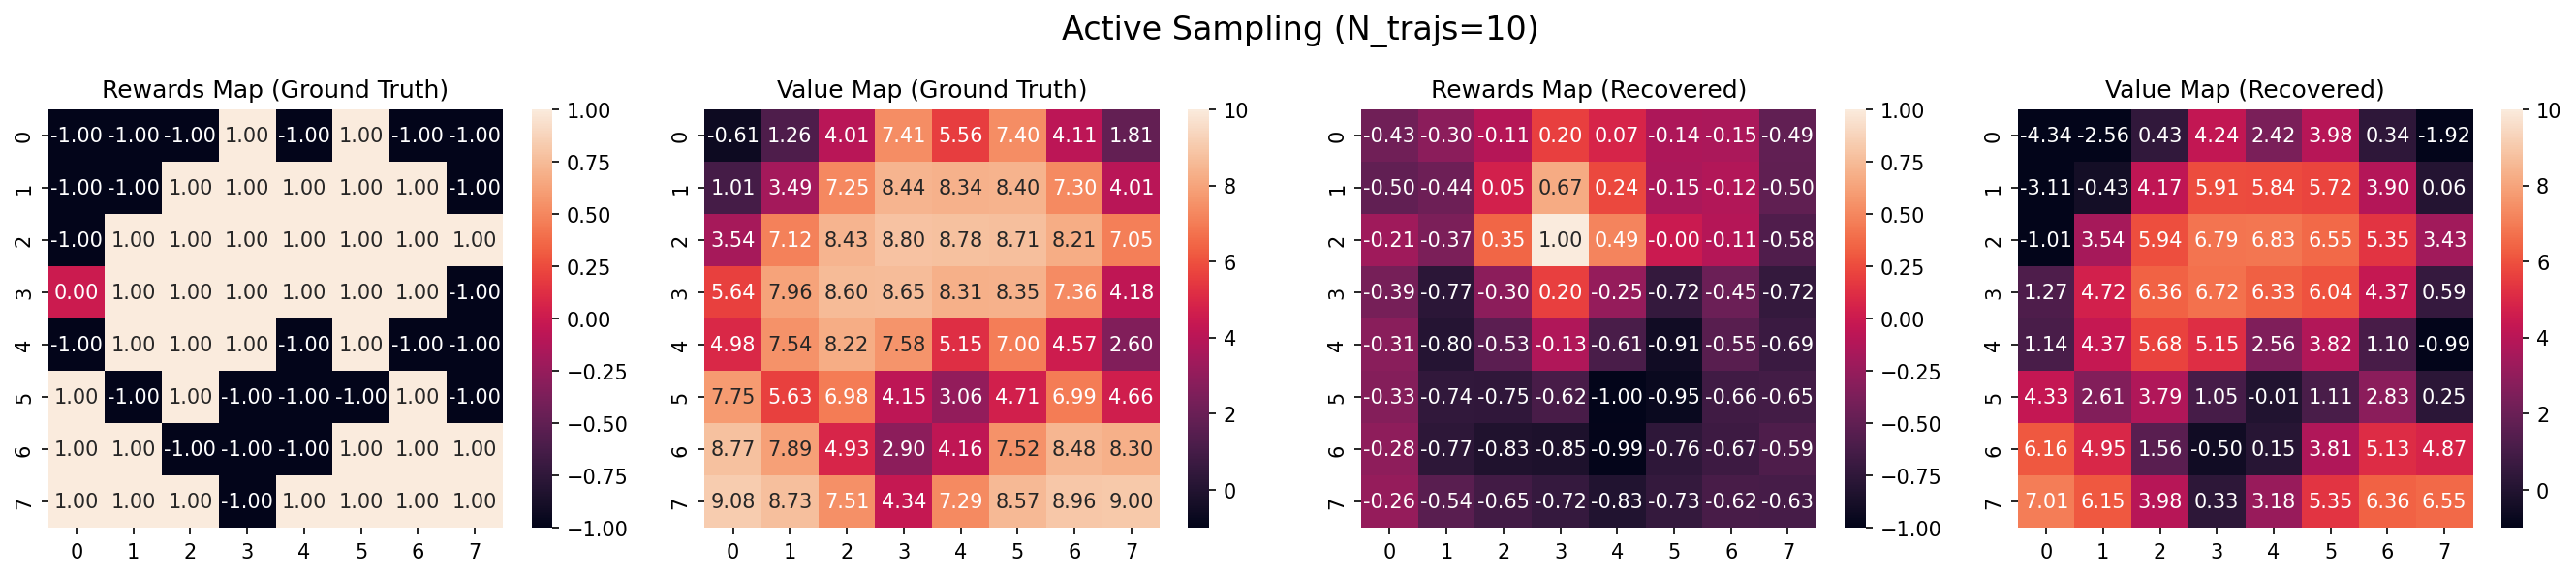

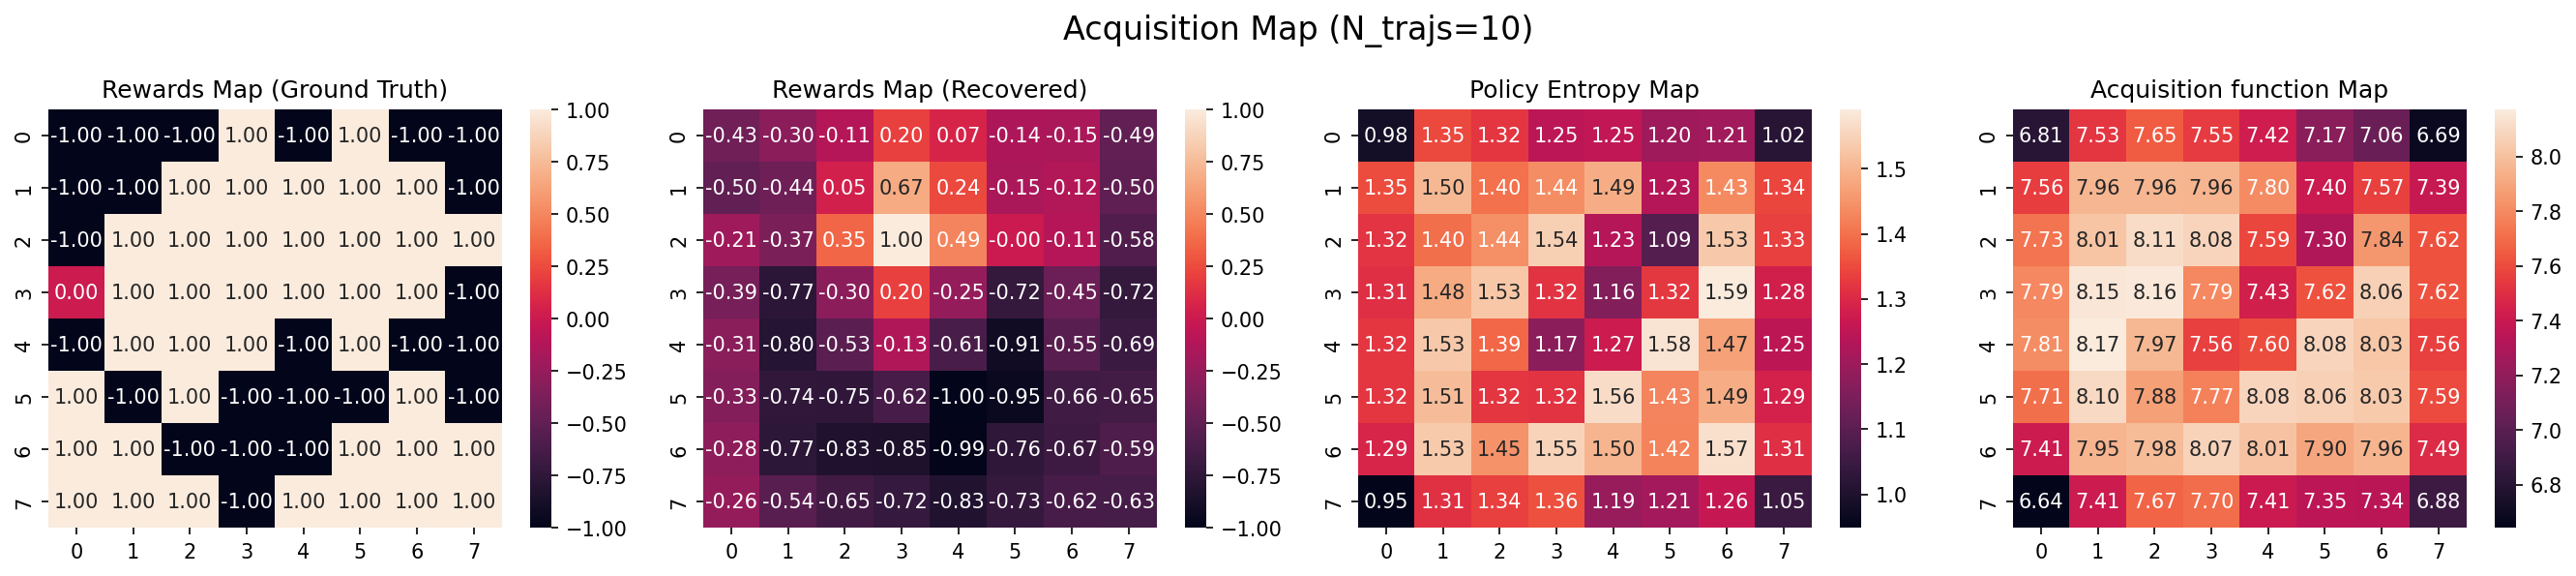

In [55]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)